# POC 3: Mix entre un algoritmo de TIFUKNN personalizado con clusterización jerárquica 

## Configuración

In [1]:
from utils import *
import polars as pl
import pandas as pd
import gower
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

In [2]:
# Read the csv files of the transactions
file_path_transactions = "../data/processed/transactions.parquet"
transactions = pl.read_parquet(file_path_transactions)
pd_transactions = transactions.to_pandas()
pd_transactions.sort_values(by=['account_id', 'invoice_date'])
# Read the csv files of the atributes
file_path_atributes = "../data/processed/atributes.parquet"
atributes = pl.read_parquet(file_path_atributes)
pd_atributes = atributes.to_pandas()
pd_atributes['poc'] = pd_atributes['poc'].astype(str)
pd_atributes.head()

,column_0,poc,bussinesssegment,totalvolumen,skudistintospromediosxorden,skudistintostotales,concentracion,segmentounico,canal
0,10,175519,HighUsage,5.18752,4.1000,16,Medio,4.Activos,Kioscos/Maxikioscos
1,13,28533,HighUsage,4.76866,3.9211,34,Alto,4.Activos,Tradicional
2,19,32182,PowerUsage,5.97930,6.7500,34,Alto,4.Activos,Tradicional
3,20,327976,MinimalUsage,6.02852,3.5833,14,Alto,4.Activos,COMIDA
4,24,354640,PowerUsage,7.52500,3.2000,18,Bajo,4.Activos,Tradicional


## Feature Engineer

### Aplicar la distancia de Gower y la agrupación jerárquica para segmentar a los usuarios

Realizamos una agrupación jerárquica en el conjunto de datos de atributos utilizando la distancia de Gower para manejar tipos de datos mixtos (categóricos y numéricos). Esto nos permitió segmentar a los usuarios en grupos según sus atributos.

El proceso:

* Distancia de Gower: esta métrica de distancia es ideal para conjuntos de datos con tipos mixtos (numéricos, ordinales categóricos y nominales categóricos).

* Agrupamiento jerárquico: utilizamos la función de enlace con el método "promedio" para realizar la agrupación aglomerativa.

* Dendrograma: el dendrograma ayuda a visualizar el proceso de agrupación y a decidir dónde cortar el árbol para formar los clústeres.

* Asignación de clústeres: utilizamos fcluster para asignar etiquetas de clústeres en función del dendrograma.

In [3]:
# Compute Gower distance matrix
gower_dist = gower.gower_matrix(pd_atributes)

/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_33067/239279650.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_dist, method='average')


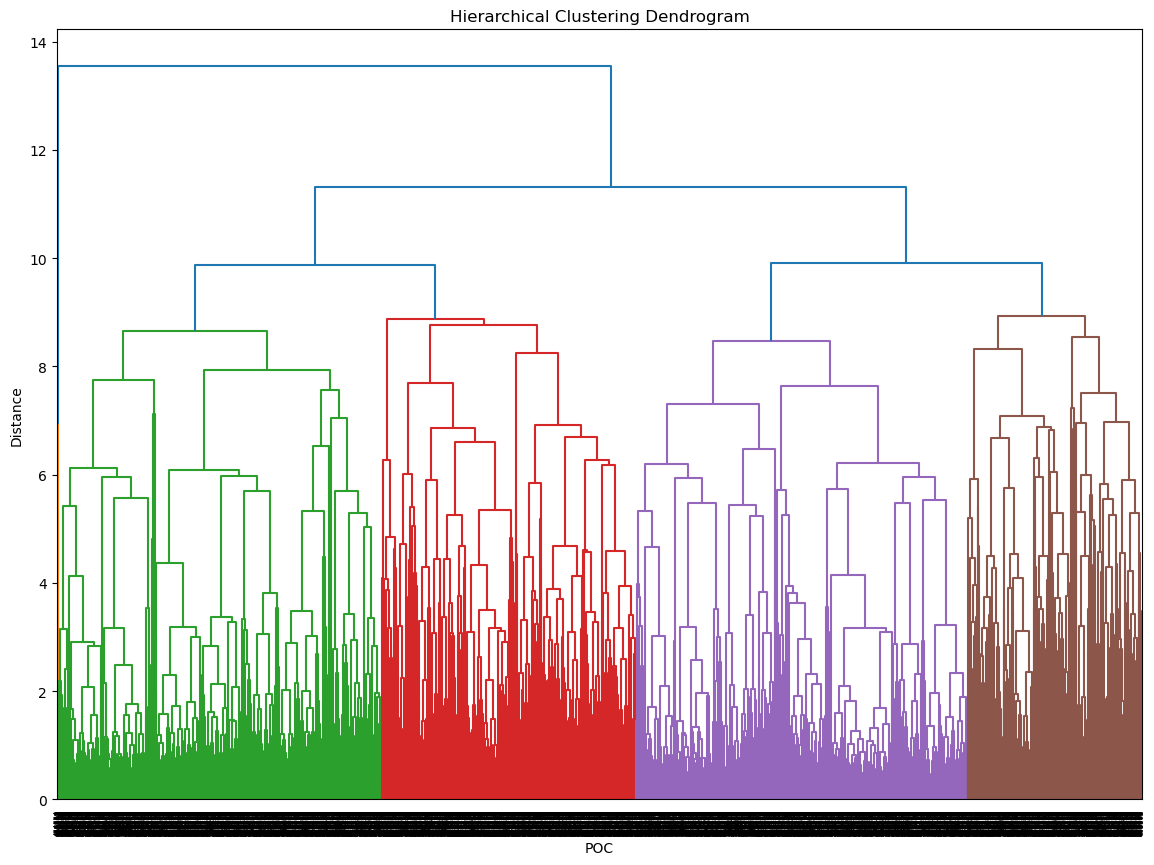

In [4]:
# Perform hierarchical clustering using the Gower distance matrix
Z = linkage(gower_dist, method='average')

# Plot the dendrogram to visualize the clusters
plt.figure(figsize=(14, 10))
dendrogram(Z, labels=pd_atributes['poc'].values)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("POC")
plt.ylabel("Distance")
plt.show()

In [5]:
num_clusters = 6
clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
pd_atributes['cluster'] = clusters
pd_atributes.groupby(by=clusters).count()['poc']

1       5
2    1313
3    1031
4    1343
5     417
6     291
Name: poc, dtype: int64

In [6]:
# Group by the clusters to understand their characteristics
numerical = ["totalvolumen","skudistintospromediosxorden","skudistintostotales"]
pd_atributes.groupby('cluster')[numerical].describe().T

cluster                                      1            2            3  \
totalvolumen                count     5.000000  1313.000000  1031.000000   
                            mean    920.381354    15.442391    24.081094   
                            std    1875.761121    66.571897    83.172525   
                            min      13.441700     0.054920     0.021240   
                            25%      56.252500     2.091260     1.987300   
                            50%      97.355290     5.268540     6.414940   
                            75%     160.413120    11.788420    18.994970   
                            max    4274.444160  1281.067160  1691.436000   
skudistintospromediosxorden count     5.000000  1313.000000  1031.000000   
                            mean      7.869040     6.474492     6.504067   
                            std       4.073639     3.517596     3.376117   
                            min       2.343600     0.750000     0.702700   
                            25%       4.809500     4.000000     4.000000   
                            50%       9.608700     5.750000     5.764700   
                            75%      11.166700     8.111100     8.142900   
                            max      11.416700    33.000000    27.428600   
skudistintostotales         count     5.000000  1313.000000  1031.000000   
                            mean     91.000000    31.926123    28.736178   
                            std      50.438081    23.144987    23.298240   
                            min      32.000000     1.000000     1.000000   
                            25%      68.000000    14.000000    11.000000   
                            50%      70.000000    26.000000    22.000000   
                            75%     128.000000    44.000000    40.000000   
                            max     157.000000   150.000000   126.000000   

cluster                                      4            5            6  
totalvolumen                count  1343.000000   417.000000   291.000000  
                            mean     18.181856    36.564326    29.650284  
                            std      79.536553   109.588173   135.287429  
                            min       0.025080     0.062060     0.045000  
                            25%       2.097970     5.262060     1.142080  
                            50%       4.934000    13.137060     3.301280  
                            75%      10.292390    28.713640     7.449120  
                            max    1322.642780  1623.862640  1665.981700  
skudistintospromediosxorden count  1343.000000   417.000000   291.000000  
                            mean      5.041289     6.068862     5.021730  
                            std       2.492491     3.478607     2.850529  
                            min       0.750000     0.750000     0.750000  
                            25%       3.292850     3.636400     3.000000  
                            50%       4.500000     5.216200     4.142900  
                            75%       6.191400     7.375000     6.112500  
                            max      21.000000    24.125000    17.333300  
skudistintostotales         count  1343.000000   417.000000   291.000000  
                            mean     23.651526    33.599520    16.109966  
                            std      17.376366    21.765916    15.034957  
                            min       1.000000     3.000000     1.000000  
                            25%      11.000000    17.000000     7.000000  
                            50%      19.000000    27.000000    11.000000  
                            75%      31.000000    46.000000    19.000000  
                            max     123.000000   113.000000   129.000000

In [7]:
pd_transactions_cluster = pd_transactions.merge(pd_atributes[['poc', 'cluster']], how='left', left_on='account_id', right_on='poc')
print(pd_transactions_cluster.shape[0])
print(100* (pd_transactions_cluster.poc.isnull().sum()/pd_transactions.shape[0]))
pd_transactions_cluster.isnull().sum()

280828
0.7235745723360918


                       0
account_id             0
sku_id                 0
invoice_date           0
order_id               0
items_phys_cases       0
poc                 2032
cluster             2032
dtype: int64

In [8]:
pd_transactions_cluster.dropna(inplace=True)
print(pd_transactions_cluster.shape)
pd_transactions_cluster.isnull().sum()

(278796, 8)


                    0
account_id          0
sku_id              0
invoice_date        0
order_id            0
items_phys_cases    0
poc                 0
cluster             0
dtype: int64

In [9]:
pd_transactions_cluster.to_parquet("../data/processed/pd_transactions_cluster.parquet")
pd_transactions_cluster.head()

,,account_id,sku_id,invoice_date,order_id,items_phys_cases,poc,cluster
0,0,430606,7038,2022-07-29,512-3880249-0,100,430606,3.0
1,1,323267,14933,2022-07-29,512-3882307-0,1,323267,6.0
2,2,357825,21971,2022-07-23,512-3852880-0,8,357825,3.0
3,3,444926,7038,2022-08-05,512-3913163-0,20,444926,3.0
4,4,450771,7030,2022-08-16,512-3957000-0,5,450771,6.0


## Entrenamiento del modelo utilizando la variable de clusterización que creamos y el algoritmo TIFUKNN.

El proceso es el siguiente:

* División de entrenamiento y prueba: dividimos los datos transaccionales en conjuntos de datos de entrenamiento y prueba utilizando períodos quincenales. El último período se utiliza para pruebas y el resto para entrenamiento.

* Implementación primaria: implementamos el algoritmo TIFUKNN (filtrado temporal basado en elementos mediante K vecinos más cercanos) mejorado por clústeres. El modelo predice la siguiente canasta de elementos para cada usuario en función de la similitud de elementos dentro de su clúster.

* Cálculo de similitud de elementos: la similitud de elementos se calcula utilizando los datos de entrenamiento, con una disminución temporal aplicada a las transacciones más antiguas para dar más peso a las interacciones recientes.

* Predicción para todos los usuarios: la función predict_next_baskets_for_all se creó para generar predicciones para todos los usuarios en el conjunto de datos de prueba. Si la estrategia principal no completa por completo las recomendaciones requeridas (k), se aplican estrategias de respaldo:

    * Respaldo 1: los elementos más comunes comprados por el usuario que también son populares en el clúster.

    * Respaldo 2: los elementos más comunes comprados solo por el usuario.

* Evaluación del modelo: Implementamos un conjunto de funciones para evaluar el desempeño del modelo utilizando métricas como Precision@K, Recall@K, F1@K, NDCG@K, PHR@K, Repetition Ratio y Exploration Ratio.

Este enfoque garantiza que la predicción de la próxima canasta se adapte al comportamiento específico de los usuarios dentro del mismo grupo, lo que genera recomendaciones personalizadas al mismo tiempo que permite incorporar un elemento de exploración en caso de ser requerido

### Separación de los datos

In [10]:
# Step 1: Determine the number of clusters
num_clusters = pd_transactions_cluster['cluster'].nunique()
print(num_clusters)
print(len(pd_transactions_cluster.account_id.unique()))
# Step 2: Calculate the number of samples per cluster
users_per_cluster = 15000 // num_clusters
print(users_per_cluster)
print(100*users_per_cluster/len(pd_transactions_cluster.account_id.unique()))
# Step 3: Sample the required number of rows from each cluster
account_ids = pd_transactions_cluster.groupby(['account_id', 'cluster']).count()['sku_id'].sample(users_per_cluster).reset_index().account_id.unique().tolist()
# Filter the DataFrame to only include rows where the account_id is in the account_ids list
sampled_df = pd_transactions_cluster[pd_transactions_cluster['account_id'].isin(account_ids)]
# Display the shape or head of the filtered DataFrame to verify
print(sampled_df.shape)
# Function to create train and test datasets using biweekly periods
train_data, test_data = split_train_test_iso(sampled_df)
print(100*sampled_df.shape[0]/pd_transactions.shape[0])
print(train_data.shape)
print(test_data.shape)
print(len(test_data.account_id.unique()))
print(100*len(sampled_df.account_id.unique())/len(pd_transactions_cluster.account_id.unique()))
print(100*len(train_data.account_id.unique())/len(pd_transactions_cluster.account_id.unique()))
print(100*len(test_data.account_id.unique())/len(pd_transactions_cluster.account_id.unique()))

6
4379
2500
57.09065996802923
(159464, 8)
56.78351161565086
(138770, 9)
(20694, 9)
1870
57.09065996802923
56.58826216031057
42.70381365608586


/Users/iairlinker/Documents/repos/challenge_AB_InBev/notebooks/utils.py:1033: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['biweekly_period'] = transactions['invoice_date'].dt.isocalendar().week // 2


### Se construye la matriz de artículos por grupo, calcula la similitud de artículos para cada grupo y se generan las predicciones

In [11]:
# Build the item-user matrix by cluster
cluster_item_user_matrices = build_item_user_matrix_by_cluster(train_data, 
                                                               cluster_col='cluster',
                                                               sku_col='sku_id',
                                                               user_col='account_id',
                                                               qty_col='items_phys_cases')
# Compute item similarity for each cluster
cluster_item_similarity = compute_similarity_by_cluster(cluster_item_user_matrices, 
                                                        train_data, 
                                                        cluster_col='cluster', 
                                                        user_col='account_id')

In [12]:
# Example of calling the function
predicted_baskets, ground_truth_baskets, user_histories, strategy_counts = predict_nb_for_all_mixed_strategy(
    test_data=test_data, 
    cluster_item_similarity=cluster_item_similarity, 
    train_data=train_data, 
    tifuknn_strategy=tifuknn_strategy,  # Your TIFUKNN strategy function
    strategy_used=strategy_used,  # Function to determine which strategy was used
    user_col='account_id', 
    cluster_col='cluster', 
    sku_col='sku_id', 
    k=8, 
    strategy_1_count=2, 
    strategy_2_count=2
)

# Analyze the output
print(f"Strategy Counts: {strategy_counts}")

Strategy Counts: {'main_strategy_count': 1848, 'fallback1_count': 0, 'fallback2_count': 0}


### Se evalúa el modelo

In [13]:
# Evaluate the model
metrics = evaluate_model_metrics(predicted_baskets, ground_truth_baskets, user_histories, k=5, n=3)
# Print the evaluation results
print(f"K items used: {5}")
for metric_name, score in metrics.items():
    print(f"{metric_name}: {score:.4f}")

K items used: 5
Avg Precision@k: 0.4066
Avg Recall@k: 0.3076
Avg F1@k: 0.3040
Avg NDCG@k: 0.5870
PHR@k: 0.8966
Avg Repetition Ratio: 0.8562
Avg Exploration Ratio: 0.1438
Avg Recallrep: 0.6874
Avg Recallexpl: 0.0080
PHRrep: 0.9080
PHRexpl: 0.0206
Avg Precision@k over n: 0.6777


Average Basket Size: 11.1288
25th Percentile: 4.0000
50th Percentile (Median): 8.0000
75th Percentile: 14.0000
maximum Basket Size: 110.0000


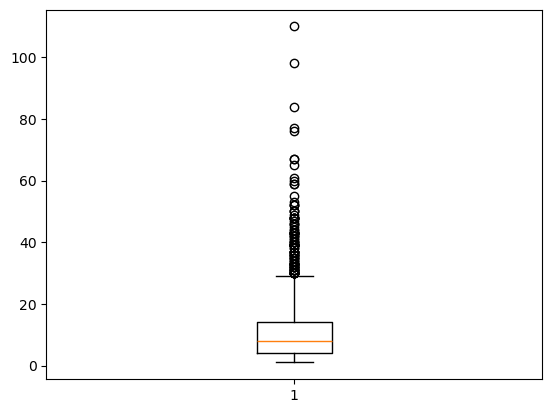

In [14]:
basket_stats = calculate_basket_statistics(ground_truth_baskets)
print(f"Average Basket Size: {basket_stats['average_size']:.4f}")
print(f"25th Percentile: {basket_stats['percentile_25']:.4f}")
print(f"50th Percentile (Median): {basket_stats['percentile_50']:.4f}")
print(f"75th Percentile: {basket_stats['percentile_75']:.4f}")
print(f"maximum Basket Size: {basket_stats['max_size']:.4f}")
plt.boxplot(basket_stats['basket_sizes']);

### Se prueban distintos parámetros en la cantidad de elementos predichos de la canasta y se evaluan los reesultados

In [15]:
# Evaluate the model
metrics = evaluate_model_metrics(predicted_baskets, ground_truth_baskets, user_histories, k=2, n=3)
# Print the evaluation results
print(f"K items of the basket: {2}")
for metric_name, score in metrics.items():
    print(f"{metric_name}: {score:.4f}")

K items of the basket: 2
Avg Precision@k: 0.5349
Avg Recall@k: 0.1767
Avg F1@k: 0.2346
Avg NDCG@k: 0.5486
PHR@k: 0.7597
Avg Repetition Ratio: 0.8562
Avg Exploration Ratio: 0.1438
Avg Recallrep: 0.6874
Avg Recallexpl: 0.0080
PHRrep: 0.9080
PHRexpl: 0.0206
Avg Precision@k over n: 0.3566


In [16]:
# Evaluate the model
metrics = evaluate_model_metrics(predicted_baskets, ground_truth_baskets, user_histories, k=4, n=3)
# Print the evaluation results
print(f"K items of the basket: {4}")
for metric_name, score in metrics.items():
    print(f"{metric_name}: {score:.4f}")

K items of the basket: 4
Avg Precision@k: 0.5060
Avg Recall@k: 0.3067
Avg F1@k: 0.3328
Avg NDCG@k: 0.5510
PHR@k: 0.8961
Avg Repetition Ratio: 0.8562
Avg Exploration Ratio: 0.1438
Avg Recallrep: 0.6874
Avg Recallexpl: 0.0080
PHRrep: 0.9080
PHRexpl: 0.0206
Avg Precision@k over n: 0.6746


In [17]:
# Evaluate the model
metrics = evaluate_model_metrics(predicted_baskets, ground_truth_baskets, user_histories, k=6, n=3)
# Print the evaluation results
print(f"K items of the basket: {6}")
for metric_name, score in metrics.items():
    print(f"{metric_name}: {score:.4f}")

K items of the basket: 6
Avg Precision@k: 0.3508
Avg Recall@k: 0.3154
Avg F1@k: 0.2879
Avg NDCG@k: 0.5936
PHR@k: 0.8977
Avg Repetition Ratio: 0.8562
Avg Exploration Ratio: 0.1438
Avg Recallrep: 0.6874
Avg Recallexpl: 0.0080
PHRrep: 0.9080
PHRexpl: 0.0206
Avg Precision@k over n: 0.7017


In [18]:
# Evaluate the model
metrics = evaluate_model_metrics(predicted_baskets, ground_truth_baskets, user_histories, k=8, n=3)
# Print the evaluation results
print(f"K items of the basket: {8}")
for metric_name, score in metrics.items():
    print(f"{metric_name}: {score:.4f}")

K items of the basket: 8
Avg Precision@k: 0.2870
Avg Recall@k: 0.3363
Avg F1@k: 0.2687
Avg NDCG@k: 0.5834
PHR@k: 0.9118
Avg Repetition Ratio: 0.8562
Avg Exploration Ratio: 0.1438
Avg Recallrep: 0.6874
Avg Recallexpl: 0.0080
PHRrep: 0.9080
PHRexpl: 0.0206
Avg Precision@k over n: 0.7653
